## Multiclass Classification Neural Network

Scaling and get_dummies

In [22]:

from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Scale continuous variables
continuous = ['BMI', 'MentHlth', 'PhysHlth']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[continuous])
X_scaled = pd.DataFrame(X_scaled, columns=continuous, index=X.index)

# 2. One-hot encode ordinal variables
X_onehot = pd.get_dummies(X[['Age', 'Education', 'Income']], drop_first=True)

# 3. Keep binary variables
binary_vars = X.drop(columns=continuous + ['Age', 'Education', 'Income'])
X_processed = pd.concat([X_scaled, X_onehot, binary_vars], axis=1)


Epoch 1/100, Loss: 731.2828
Epoch 2/100, Loss: 701.6628
Epoch 3/100, Loss: 691.9431
Epoch 4/100, Loss: 682.0597
Epoch 5/100, Loss: 672.2309
F1 per classe - Epoch 5: 0: 0.9084, 1: 0.0519, 2: 0.3392
Epoch 6/100, Loss: 664.3875
Epoch 7/100, Loss: 656.5239
Epoch 8/100, Loss: 646.4475
Epoch 9/100, Loss: 639.3318
Epoch 10/100, Loss: 633.1601
F1 per classe - Epoch 10: 0: 0.8979, 1: 0.0550, 2: 0.3581
Epoch 11/100, Loss: 623.5161
Epoch 12/100, Loss: 620.1290
Epoch 13/100, Loss: 613.0046
Epoch 14/100, Loss: 608.7207
Epoch 15/100, Loss: 602.4077
F1 per classe - Epoch 15: 0: 0.9013, 1: 0.0567, 2: 0.3488
Epoch 16/100, Loss: 596.4814
Epoch 17/100, Loss: 593.6824
Epoch 18/100, Loss: 589.6144
Epoch 19/100, Loss: 582.9673
Epoch 20/100, Loss: 579.3698
F1 per classe - Epoch 20: 0: 0.9050, 1: 0.0605, 2: 0.2436
Epoch 21/100, Loss: 575.5728
Epoch 22/100, Loss: 571.9726
Epoch 23/100, Loss: 568.8229
Epoch 24/100, Loss: 564.3297
Epoch 25/100, Loss: 561.1472
F1 per classe - Epoch 25: 0: 0.9016, 1: 0.0498, 2: 0.

C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Log Loss: 0.4917
Cohen's Kappa: 0.2359


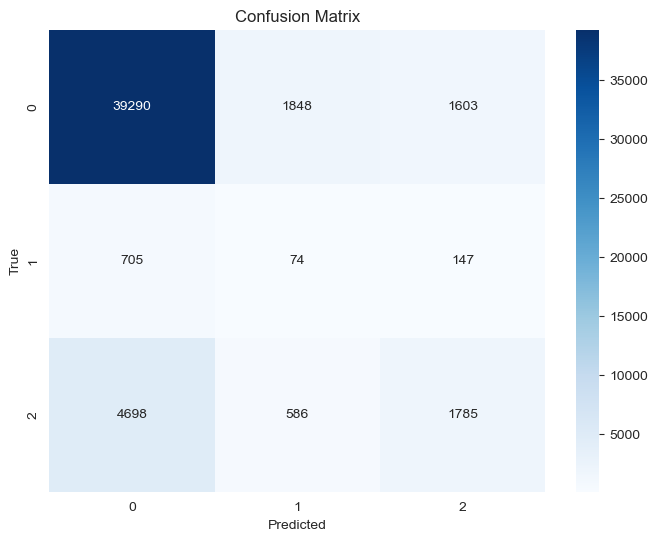

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SMOTE RESAMPLING ====
sm = SMOTE(sampling_strategy={1: 40000, 2: 40000}, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


# ==== 4. TORCH DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 5. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        """
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )"""
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 6. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 7. MODEL SETUP ====
model = DiabetesModel(X_processed.shape[1])

# Compute class weights from resampled set
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float32)
weights = weights / weights.sum()

#criterion = FocalLoss(gamma=1.5, weight=weights)
criterion = FocalLoss(gamma=2.0, weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100


def compute_f1_by_class(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())
    return f1_score(y_true, y_pred, average=None)


# ==== 8. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")
    if (epoch + 1) % 5 == 0:
        f1s = compute_f1_by_class(model, test_loader)
        print(f"F1 per classe - Epoch {epoch + 1}: 0: {f1s[0]:.4f}, 1: {f1s[1]:.4f}, 2: {f1s[2]:.4f}")

# ==== 9. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 10. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 11. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


scaled and hyperparameter 

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import random

# ==== DATASET & PREPROCESSING ====
# X_processed and y must be defined before this code.
# X_processed: DataFrame, y: Series or array-like

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

sm = SMOTE(sampling_strategy={1: 40000, 2: 40000}, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test, y_test)

# ==== FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt

# ==== TRAINING & EVALUATION FUNCTION ====
def train_and_evaluate(params):
    lr = params['lr']
    gamma = params['gamma']
    hidden_sizes = params['hidden_sizes']
    dropout = params['dropout']
    batch_size = params['batch_size']
    epochs = params['epochs']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    class CustomModel(nn.Module):
        def __init__(self, input_dim, hidden_sizes, dropout):
            super().__init__()
            layers = []
            last_dim = input_dim
            for h in hidden_sizes:
                layers.extend([
                    nn.Linear(last_dim, h),
                    nn.BatchNorm1d(h),
                    nn.ReLU(),
                    nn.Dropout(dropout)
                ])
                last_dim = h
            layers.append(nn.Linear(last_dim, 3))
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    model = CustomModel(X_processed.shape[1], hidden_sizes, dropout)
    criterion = FocalLoss(gamma=gamma)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    f1 = f1_score(y_true, y_pred, average='macro')
    return f1, model, params

# ==== RANDOM SEARCH ====
param_space = {
    'lr': [1e-4, 5e-4, 1e-3],
    'gamma': [1.0, 1.5, 2.0],
    'dropout': [0.2, 0.3, 0.4],
    'batch_size': [32, 64, 128],
    'hidden_sizes': [
        [128, 64],
        [256, 128, 64],
        [512, 256, 128, 64]
    ],
    'epochs': [20, 30, 40]
}

best_f1 = 0
best_model = None
best_params = None
results = []

for i in range(10):
    params = {k: random.choice(v) for k, v in param_space.items()}
    f1, model, config = train_and_evaluate(params)
    results.append({**config, 'f1_macro': f1})
    print(f"[{i+1}/10] Params: {config} => F1-macro: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_params = config

# ==== BEST RESULTS ====
print("\nBest Hyperparameters Found:")
print(best_params)

# ==== FINAL EVALUATION ====
model = best_model
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Log Loss:          {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa:     {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ==== OPTIONAL: SAVE RESULTS ====
df_results = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False)
df_results.to_csv("tuning_results.csv", index=False)


General Scaling and no features selection

Epoch 1/30, Loss: 3497.8284
Epoch 2/30, Loss: 3318.8730
Epoch 3/30, Loss: 3224.0311
Epoch 4/30, Loss: 3164.5853
Epoch 5/30, Loss: 3127.6282
Epoch 6/30, Loss: 3092.7965
Epoch 7/30, Loss: 3064.3518
Epoch 8/30, Loss: 3045.7772
Epoch 9/30, Loss: 3028.4297
Epoch 10/30, Loss: 3007.9048
Epoch 11/30, Loss: 2993.3491
Epoch 12/30, Loss: 2982.5914
Epoch 13/30, Loss: 2973.4740
Epoch 14/30, Loss: 2963.9542
Epoch 15/30, Loss: 2955.3092
Epoch 16/30, Loss: 2944.3504
Epoch 17/30, Loss: 2940.1772
Epoch 18/30, Loss: 2933.6689
Epoch 19/30, Loss: 2922.9924
Epoch 20/30, Loss: 2918.8513
Epoch 21/30, Loss: 2911.3387
Epoch 22/30, Loss: 2910.0014
Epoch 23/30, Loss: 2902.5094
Epoch 24/30, Loss: 2905.1609
Epoch 25/30, Loss: 2900.0250
Epoch 26/30, Loss: 2902.3555
Epoch 27/30, Loss: 2885.8035
Epoch 28/30, Loss: 2887.3257
Epoch 29/30, Loss: 2883.3565
Epoch 30/30, Loss: 2876.4042

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     42741

C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


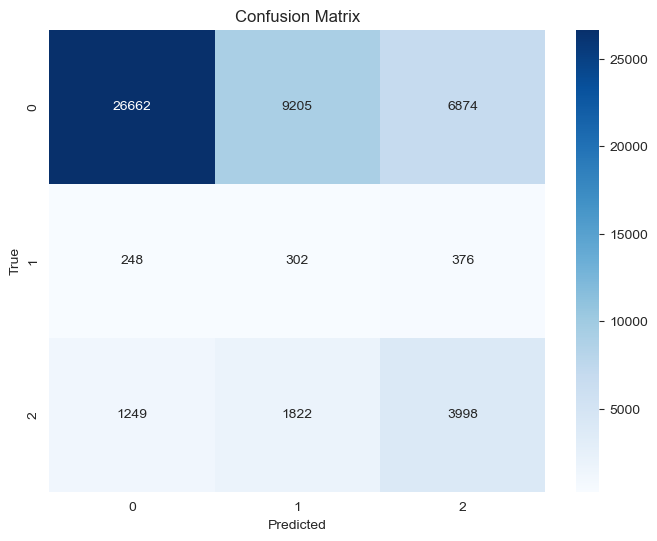

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 4. SMOTE RESAMPLING ====
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# ==== 5. CUSTOM DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==== 6. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)

# ==== 7. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt

# ==== 8. MODEL SETUP ====
model = DiabetesModel(X.shape[1])

# Compute class weights based on inverse frequency (from resampled training set)
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 9. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 10. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 11. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 12. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 4. SMOTE RESAMPLING ====
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)


# ==== 5. CUSTOM DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 6. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 7. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 8. MODEL SETUP ====
model = DiabetesModel(X.shape[1])

# Compute class weights based on inverse frequency (from resampled training set)
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 9. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 10. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 11. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 12. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


With features selection(multinomial)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ==== 2. FEATURE SELECTION (Multinomial logistic regression) ====

selected_cols = multinomial(X)
if 'const' in selected_cols:
    selected_cols.remove('const')
X_model = X[selected_cols]

# ==== 3. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 4. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 5. SMOTE ====
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


# ==== 6. TORCH DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame) or isinstance(X, np.ndarray):
            X = np.array(X)
        if isinstance(y, pd.Series):
            y = y.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 7. MODEL ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 8. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 9. TRAIN SETUP ====
input_dim = X_resampled.shape[1]
model = DiabetesModel(input_dim)

class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 10. TRAIN LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 11. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 12. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 13. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_2.png")
plt.show()

With features selection(kbest)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# 1. Feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)  # restituisce un ndarray con 10 feature

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# 5. input_dim per la rete
input_dim = X_resampled.shape[1]


# ==== 6. TORCH DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame) or isinstance(X, np.ndarray):
            X = np.array(X)
        if isinstance(y, pd.Series):
            y = y.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 7. MODEL ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 8. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 9. TRAIN SETUP ====

model = DiabetesModel(input_dim)

class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 10. TRAIN LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 11. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 12. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 13. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_3.png")
plt.show()